In [1]:
# Change the dataset in global_vars.py to NAKO.
from global_vars import *
from commons import *

import glob 
import os

one_time_n4_optimization = True
vol_to_check_list = None #['100025']
exclude = ['100006', '100008']  # No SPleen
# 181
%load_ext autoreload
%autoreload 2

In [2]:
def load_nako_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for name in os.listdir(data_dir)]
    
    file_paths = {}
    
    for vol in volumes_to_use:
        if vol != '100112':
            continue
        if (vol_to_check_list is not None and vol not in vol_to_check_list) or (vol == "") or (vol in exclude):
            continue
        opp_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_opp/**.nii.gz') # **_2**
        in_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_in/**.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_F/**.nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_W/**.nii.gz')
        
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths

file_paths = load_nako_file_paths()
file_paths

{'100112': {'VOLUME_PATHS': {'OPP': ['/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100112/100112_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_1.nii.gz',
    '/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100112/100112_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_2.nii.gz',
    '/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100112/100112_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_3.nii.gz',
    '/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100112/100112_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_4.nii.gz'],
   'IN': ['/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100112/100112_3D_GRE_TRA_in/3D_GRE_TRA_in_3D_GRE_TRA_1_e2.nii.gz',
    '/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100112/100112_3D_GRE_TRA_in/3D_GRE_TRA_in_3D_GRE_TRA_2_e2.nii.gz',
    '/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100112/100112_3D_GRE_TRA_in/3D_GRE_TRA_in_3D_GRE_TRA_3_e2.nii.gz',
    '/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100112/100112_3D_GRE_TRA_in/3D_GRE_TRA_in_3D_GRE_TRA_4_e2.nii.gz'],
   'F': ['/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI

In [3]:
# glob.glob(f'{data_dir}/{vol}/**/**.nii.gz')

In [4]:
# vol = '100008'
# a = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_W/**.nii.gz')
# volume_3_view_viewer(get_volume_data(nb.load('/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100008/100008_3D_GRE_TRA_W_COMPOSED/3D_GRE_TRA_W_COMPOSED_-23_3D_GRE_TRA_4_e2.nii.gz')))

In [5]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [6]:
# SITK does ot work due to differences in pixel resolution of IN and corresponding OPP Scan.
# Only applying once at the end.
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4-biasfield-correction starting with {vol}...')
    for idx, n4_d in enumerate(n4_dict[vol]):
        in_file = n4_d['SCALED']
        opp_file = file_paths[vol]['VOLUME_PATHS']['OPP'][idx]
        new_filename = opp_file.split('/')[-1].split('.')[0]
        output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_sitk.nii.gz'
        SITK_N4_normalization(in_file, opp_file, output_file)
        n4_dict[vol][idx]['OPP_CORRECTED'] = output_file

    file_paths[vol]['N4_1'] = n4_dict[vol]

In [7]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    try:
        print(f'started with {vol}...')
        if vol_to_check_list is not None and vol not in vol_to_check_list:
            continue
#         if vol not in ['100112']:
#             continue
        create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
        file_paths[vol]['ONE'] = {}
        for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
            print(f"processing {modality_key}")
            orig_modal_key = modality_key
            if one_time_n4_optimization:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
            else:
                if modality_key == 'OPP':
                    vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                    modality_key = modality_key+'_n4_corrected'
                else:
                    vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

            ras_stitched = multi_vol_stitching(vol_parts)
            save_volume(ras_stitched, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched', np.int16)
            file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'
    except Exception as e:
        print('ERROR:',e)
        continue

started with 100112...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -223.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -405.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -223.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -597.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -223.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -825.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 1.406

In [8]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    try:
        if vol_to_check_list is not None and vol not in vol_to_check_list:
            continue
#         if vol not in ['100112']:
#             continue
        print(f'n4 processing part-2 started with {vol}...')
        n4_dict[vol] = {}
        in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
        n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)
        
    except Exception as e:
        print('ERROR:',e)
        continue

n4 processing part-2 started with 100112...
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0650000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)
Transforming Images to RAS.....
-159.7657470703125
neagtive value detected
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/NAKO/n4_corrected_2/vol/100112


In [9]:
all_n4_process = True
for vol in file_paths.keys():
    try:
        if vol_to_check_list is not None and vol not in vol_to_check_list:
            continue
#         if vol not in [ '100112']:
#             continue
        print(f'n4-biasfield-correction starting with {vol}...')
        in_file = n4_dict[vol]['N4_2']['SCALED']
        opp_file = file_paths[vol]['ONE']['OPP']
        if all_n4_process:
            w_file = file_paths[vol]['ONE']['W']
            w_of = w_file.split('/')[-1].split('.')[0]
            w_outputfile = f'{n4_corrected_data_dir}/vol/{vol}/{w_of}_n4_corrected_sitk.nii.gz'
            SITK_N4_normalization(in_file, w_file, w_outputfile)
            n4_dict[vol]['N4_2']['W_CORRECTED'] = w_outputfile
            
            f_file = file_paths[vol]['ONE']['F']
            f_of = f_file.split('/')[-1].split('.')[0]
            f_outputfile = f'{n4_corrected_data_dir}/vol/{vol}/{f_of}_n4_corrected_sitk.nii.gz'
            SITK_N4_normalization(in_file, f_file, f_outputfile)
            n4_dict[vol]['N4_2']['F_CORRECTED'] = f_outputfile
            
            inin_file = file_paths[vol]['ONE']['IN']
            in_of = inin_file.split('/')[-1].split('.')[0]
            in_outputfile = f'{n4_corrected_data_dir}/vol/{vol}/{in_of}_n4_corrected_sitk.nii.gz'
            SITK_N4_normalization(in_file, inin_file, in_outputfile)
            n4_dict[vol]['N4_2']['IN_CORRECTED'] = in_outputfile
        new_filename = opp_file.split('/')[-1].split('.')[0]
        output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_sitk.nii.gz'
        SITK_N4_normalization(in_file, opp_file, output_file)
        n4_dict[vol]['N4_2']['OPP_CORRECTED'] = output_file
        file_paths[vol]['N4_2'] = n4_dict[vol]['N4_2']
    except Exception as e:
        print('ERROR:',e)
        continue

n4-biasfield-correction starting with 100112...
done
done
done
done


In [10]:
def nako_vol_label_fix(vol, label):
    world_shape = np.max(np.array([list(vol.shape), list(label.shape)]), axis=0)
    final_label = np.zeros(tuple(world_shape))

    label_affine = label.affine
    vol_affine = vol.affine
    
    target_affine = vol_affine
    target_header = vol.header
    target_dim_v = vol.shape

    sx,sy,sz,ex,ey,ez = np.abs(get_points(label, vol))
    
    final_label[0:ex+sx, 0:ey+sy, sz:ez] = label.get_fdata()
    
    final_label = np.flip(final_label, axis=0)
    final_label = np.flip(final_label, axis=1)
    
    final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
    return vol, final_label_img

def nako_label_parts(label_parts, reference_labelmap=None):
    stitched_label = None
    mode = 'constant'
    order = 0
    if reference_labelmap is None:
        label_shape = get_freequent_shape([img.shape for img, _, _ in label_parts])
        reference_labelmap = [img for img, _, _ in label_parts if list(img.shape) == list(label_shape)][0]
    else:
        label_shape = reference_labelmap.shape

    stitched_label = np.zeros(label_shape)
    for labelmap_img, lidx, lname in label_parts:
        print(lidx, lname)
        labelmap_img = makeit_3d(labelmap_img)
        labelmap_img = resample_from_to(labelmap_img, [label_shape, reference_labelmap.affine], order=order, mode=mode, cval=0)
        
        sx,sy,sz,ex,ey,ez = np.abs(get_points(labelmap_img, reference_labelmap))
        
        labelmap = labelmap_img.get_fdata()
        labelmap = np.multiply(lidx, labelmap)
        stitched_label[0:ex+sx, 0:ey+sy, 0:ez+sz] += labelmap
        
        print("###############################################################################################") 
        
    labelmap = np.round(stitched_label)
    stitched_labeled_img = nb.Nifti1Image(labelmap, reference_labelmap.affine, reference_labelmap.header)
    
    return stitched_labeled_img

STARTING NAKO LABEL-MAPS.
Reading Label Maps.....
100112
['datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Liver.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2-2.NRRD_ADRENALGLAND(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLM

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2_SPLEEN.NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2_SPLEEN.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2_SPLEEN.NRRD
SPL DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2_SPLEEN.NRRD
[True, True] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2-2.NRRD_ADRENALGLAND(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2-2.NRRD_ADRENALGLAND(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2-2.NRRD_ADRENALGLAND(LEFT).NRRD
SPL DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2-2.NRRD_ADRENALGLAND(LEFT).NRRD
[False, False] False
KIDNEY_

/home/abhijit/anaconda3/envs/remotenv/lib/python3.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


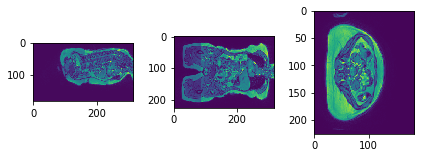

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0650000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


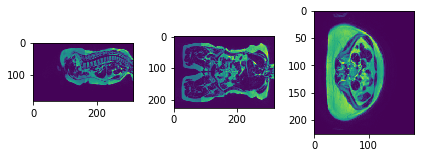

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0650000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 88)


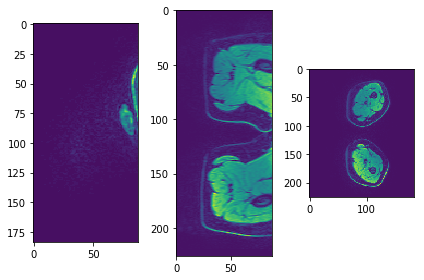

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0650000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


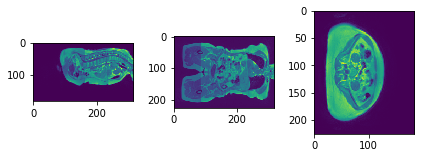

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0650000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


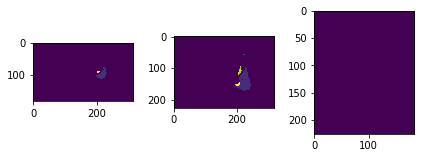

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/NAKO/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/NAKO/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/NAKO/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/NAKO/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/NAKO/processed/label
FINISHED.


In [11]:
print("STARTING NAKO LABEL-MAPS.")
print('Reading Label Maps.....')
flag = True
for vol in file_paths.keys():
    print(vol)
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
#     if vol == '100083':
#         flag = False
#     if flag:
#         continue
    later = []
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
    volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
    f_volume = nb.load(file_paths[vol]['N4_2']['F_CORRECTED'])
    w_volume = nb.load(file_paths[vol]['N4_2']['W_CORRECTED'])
    in_volume = nb.load(file_paths[vol]['N4_2']['IN_CORRECTED'])
#     volume = nb.load(file_paths[vol]['ONE']['OPP'])
    img_ras_list = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if labelname is None or img_ras is None:
            continue
        img_ras = makeit_3d(img_ras)
        img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=0, mode='constant', cval=0)
        if labelname == 'SPLEEN':
            later.append([img_ras, lidx+LABEL_EXTENSION_FOR_OVERLAP_REMOVAL, labelname])
        else:
            img_ras_list.append([img_ras, lidx+LABEL_EXTENSION_FOR_OVERLAP_REMOVAL, labelname])
    
    img_ras_list.extend(later)
    
    s_label = nako_label_parts(img_ras_list)
    s_label = drop_overlapped_pixels(s_label, np.array(img_ras_list)[:, 1])
    volume, s_label = nako_vol_label_fix(volume, s_label)

    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))
    volume_3_view_viewer(get_volume_data(f_volume))
    volume_3_view_viewer(get_volume_data(w_volume))
    volume_3_view_viewer(get_volume_data(in_volume))
    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(f_volume, f'{processed_dir}/volume_f/{vol}')
    save_volume(w_volume, f'{processed_dir}/volume_w/{vol}')
    save_volume(in_volume, f'{processed_dir}/volume_in/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    print('FINISHED.')